In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
import matplotlib.pyplot as plt
import joblib
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional
from keras.regularizers import l2

In [2]:
file_path= "C:/Users/vgarciario/desktop/UA MASTER/labo3/final_dataset_descr.csv"
df1 = pd.read_csv(file_path, sep='\t')

file_path2= "C:/Users/vgarciario/desktop/UA MASTER/labo3/productos_a_predecir.txt"
pp= pd.read_csv(file_path2, sep='\t')

In [3]:
df = pd.merge(df1, pp, on='product_id', how='inner')

In [4]:
df.columns

Index(['periodo', 'customer_id', 'product_id', 'plan_precios_cuidados',
       'cust_request_qty', 'cust_request_tn', 'tn', 'cat1', 'cat2', 'cat3',
       'brand', 'sku_size', 'descripcion', 'quarter', 'month', 'close_quarter',
       'age'],
      dtype='object')

In [7]:
# df.drop(columns=['plan_precios_cuidados', 'cust_request_qty','cust_request_tn','quarter', 'month', 'close_quarter', 'age'], inplace=True)

In [5]:
df.columns

Index(['periodo', 'customer_id', 'product_id', 'plan_precios_cuidados',
       'cust_request_qty', 'cust_request_tn', 'tn', 'cat1', 'cat2', 'cat3',
       'brand', 'sku_size', 'descripcion', 'quarter', 'month', 'close_quarter',
       'age'],
      dtype='object')

In [4]:
#Paso1: reemplazar 082019 por promedio 07 y 09
df['periodo'] = df['periodo'].astype(str).str.strip()

# Filtrar los datos por los periodos 201907, 201908 y 201909
df_filtered = df[df['periodo'].isin(['201907', '201908', '201909'])]

# # Pivotear los datos para tener columnas separadas para cada periodo
pivoted_sales = df_filtered.pivot_table(index=['product_id', 'customer_id'], columns='periodo', values='tn').reset_index()

# # Asegurar que las columnas 201907 y 201909 existen en el DataFrame
pivoted_sales = pivoted_sales.reindex(columns=['product_id', 'customer_id', '201907', '201908', '201909'])

# # Calcular el promedio de julio y septiembre
pivoted_sales['201908'] = pivoted_sales[['201907', '201909']].mean(axis=1)

# # Convertir de nuevo al formato largo
updated_sales = pivoted_sales.melt(id_vars=['product_id', 'customer_id'], value_vars=['201907', '201908', '201909'], 
                                   var_name='periodo', value_name='tn')

# # Unir con el dataframe original
df.set_index(['product_id', 'customer_id', 'periodo'], inplace=True)
df.update(updated_sales.set_index(['product_id', 'customer_id', 'periodo']))
df.reset_index(inplace=True)

display(df)

,product_id,customer_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,quarter,month,close_quarter,age
0,20001,10001,201701,0,11,99.43861,99.43861,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,1,0,0
1,20001,10002,201701,0,17,38.68301,35.72806,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,1,0,0
2,20001,10003,201701,0,17,143.49426,143.49426,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,1,0,0
3,20001,10004,201701,0,9,184.72927,184.72927,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,1,0,0
4,20001,10005,201701,0,23,19.08407,19.08407,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293476,21214,10430,201912,0,1,0.00179,0.00179,PC,DEOS,RollOn,NIVEA,50,Aroma 14,Q4,12,1,3
2293477,21214,10441,201912,0,1,0.00239,0.00239,PC,DEOS,RollOn,NIVEA,50,Aroma 14,Q4,12,1,3
2293478,21214,10448,201912,0,1,0.00299,0.00299,PC,DEOS,RollOn,NIVEA,50,Aroma 14,Q4,12,1,3
2293479,21214,10505,201912,0,1,0.00179,0.00179,PC,DEOS,RollOn,NIVEA,50,Aroma 14,Q4,12,1,3


In [5]:
# Filtrar el DataFrame para los meses y IDs específicos
df_subset = df[(df['product_id'] == 20001) & (df['customer_id'] == 10001)]

# Imprimir el resultado
print(df_subset[['product_id', 'customer_id', 'periodo', 'tn']])
df_subset.tail(10)

      product_id  customer_id periodo         tn
0          20001        10001  201701   99.43861
186        20001        10001  201702  198.84365
371        20001        10001  201703   92.46537
559        20001        10001  201704   13.29728
663        20001        10001  201705  101.00563
901        20001        10001  201706  128.04792
1121       20001        10001  201707  101.20711
1272       20001        10001  201708   43.33930
1508       20001        10001  201709  289.35024
1671       20001        10001  201710  222.11389
1767       20001        10001  201711  111.54944
1942       20001        10001  201712  131.27150
2134       20001        10001  201801   49.61857
2286       20001        10001  201802   88.44065
2443       20001        10001  201803  214.72336
2647       20001        10001  201804  132.83419
2801       20001        10001  201805  165.73507
2989       20001        10001  201806   92.29410
3177       20001        10001  201807  256.05760
3344       20001    

,product_id,customer_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,quarter,month,close_quarter,age
4530,20001,10001,201903,0,23,142.87158,130.54927,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,3,1,26
4721,20001,10001,201904,0,33,364.37071,364.37071,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q2,4,0,27
4898,20001,10001,201905,0,31,439.90647,439.90647,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q2,5,0,28
5020,20001,10001,201906,0,7,65.92436,65.92436,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q2,6,1,29
5202,20001,10001,201907,0,14,144.78714,144.78714,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q3,7,0,30
5383,20001,10001,201908,0,9,33.63991,126.91979,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q3,8,0,31
5546,20001,10001,201909,0,18,111.51691,109.05244,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q3,9,1,32
5712,20001,10001,201910,0,21,178.49426,176.02980,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q4,10,0,33
5840,20001,10001,201911,0,21,240.59870,236.65556,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q4,11,0,34
5996,20001,10001,201912,0,18,214.72185,180.21938,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q4,12,1,35


In [6]:
# Paso 2: Buscar los 'product_id' que tengan poca historia
training_threshold = 12

# Contar el número de registros por product_id, customer_id y periodo
product_history = df.groupby(['product_id', 'customer_id']).size().reset_index(name='counts')

# Filtrar productos por customer_id con menos registros que el threshold
products_to_keep = product_history[product_history['counts'] >= training_threshold][['product_id', 'customer_id']].drop_duplicates()
df_filtered = df.merge(products_to_keep, on=['product_id', 'customer_id'], how='inner')


In [7]:

# Paso 3: Aplicar LabelEncoder a las columnas categoricas
categorical_cols = ['cat1', 'cat2', 'cat3', 'brand', 'descripcion']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_filtered[col] = le.fit_transform(df_filtered[col])
    label_encoders[col] = le



In [9]:
# Paso 4: Agrupar las ventas por periodo, cat1, cat2, cat3, marca y descripcion

# Supongamos que 'periodo' es una columna de tipo string con formato 'YYYYMM'
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m', errors='coerce')

# Filtrar datos para diciembre de 2019
df_diciembre_2019 = df[(df['periodo'].dt.year == 2019) & (df['periodo'].dt.month == 12)]

# Agrupar las ventas del año 2019 por periodo, cat1, cat2, cat3, brand, descripcion y product_id
grouped_sales_2019 = df_diciembre_2019.groupby(['cat1', 'cat2', 'cat3', 'brand','product_id'])['tn'].sum().reset_index()
#'periodo', 'cat1', 'cat2', 'cat3', 'brand', 'descripcion', 

# Calcular el promedio de ventas por periodo para el año 2019 por grupo de cat1, cat2, cat3, brand, descripcion y product_id
#average_sales_2019 = grouped_sales_2019.groupby(['cat1', 'cat2', 'cat3', 'brand', 'descripcion', 'product_id'])['tn'].mean().reset_index()

# Calcular el promedio total de ventas por grupo de cat1, cat2, cat3, brand y descripcion para el año 2019
group_totals_2019 = df_diciembre_2019.groupby(['cat1', 'cat2', 'cat3', 'brand'])['tn'].sum().reset_index()

# Unir para calcular el ratio
ratios_2019 = pd.merge(grouped_sales_2019, group_totals_2019, on=['cat1', 'cat2', 'cat3', 'brand'], suffixes=('', '_total'))
ratios_2019['ratio'] = ratios_2019['tn'] / ratios_2019['tn_total']

# Crear un diccionario de ratios
ratio_dict = ratios_2019.set_index(['cat1', 'cat2', 'cat3', 'brand', 'product_id'])['ratio'].to_dict()


In [10]:
# Filtrar el DataFrame para los meses y IDs específicos
df_subset = ratios_2019[(ratios_2019['product_id'] == 20001)]

# Imprimir el resultado
print(df_subset)
df_subset.tail(10)

    cat1         cat2     cat3  brand  product_id          tn    tn_total  \
242   HC  ROPA LAVADO  Liquido  ARIEL       20001  1504.68856  1892.55454   

        ratio  
242  0.795057  


,cat1,cat2,cat3,brand,product_id,tn,tn_total,ratio
242,HC,ROPA LAVADO,Liquido,ARIEL,20001,1504.68856,1892.55454,0.795057


In [11]:

# Paso 5: Agrupar las ventas por periodo, cat1, cat2, cat3, marca y customer_id
grouped_df = df_filtered.groupby(['periodo', 'cat1', 'cat2', 'cat3', 'brand', 'customer_id']).agg({
    'cust_request_qty': 'sum',
    'cust_request_tn': 'sum',
    'tn': 'sum'
}).reset_index()

# Crear un diccionario para almacenar los scalers
scalers = {}
scaled_df = grouped_df.copy()

# Aplicar StandardScaler a cada columna de interés
for col in ['cust_request_qty', 'cust_request_tn', 'tn']:
    scaler = StandardScaler()
    scaled_df[col] = scaler.fit_transform(scaled_df[[col]])
    scalers[col] = scaler

# Guardar los scalers para su uso posterior
joblib.dump(scalers, 'scalers.pkl')


['scalers.pkl']

In [12]:
# Paso 6: Agrupar en clusters con dtw y hacer grafico de codo para determinar la cantidad optima de clusters
pivot_table = scaled_df.pivot_table(index=['customer_id', 'cat1', 'cat2', 'cat3', 'brand'], columns='periodo', values='tn', fill_value=0)
time_series_data = pivot_table.values
scaler = TimeSeriesScalerMinMax()
time_series_data = scaler.fit_transform(time_series_data)

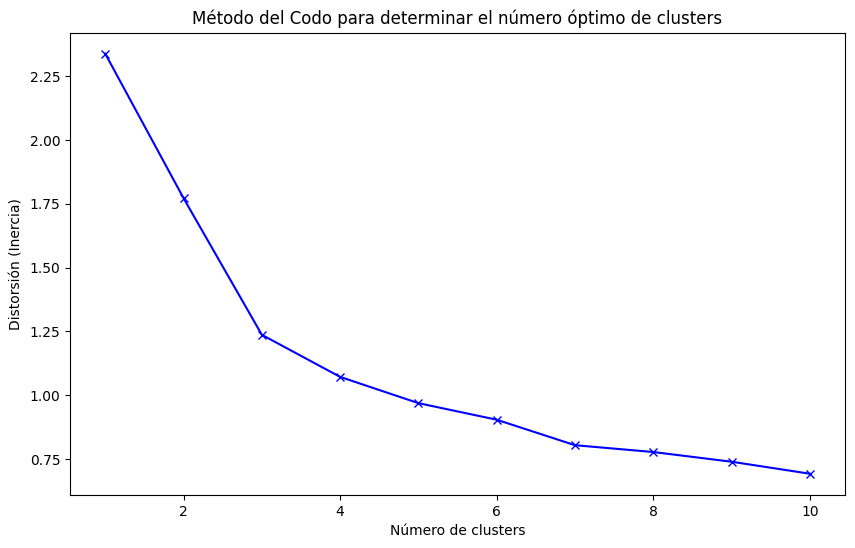

In [105]:
# Método del codo para determinar el número óptimo de clusters
distortions = []
K = range(1, 11)
for k in K:
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10, random_state=0)
    model.fit(time_series_data)
    distortions.append(model.inertia_)

# Graficar el codo
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Distorsión (Inercia)')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.show()



In [13]:
# Suponiendo que el codo sugiere 7 clusters (ajustar según el gráfico)
optimal_clusters = 10
model = TimeSeriesKMeans(n_clusters=optimal_clusters, metric="dtw", max_iter=10, random_state=0)
labels = model.fit_predict(time_series_data)
pivot_table['cluster'] = labels


In [14]:
# Primero, reseteamos el índice para convertirlo en columnas
pivot_table_reset = pivot_table.reset_index()

# Luego, combinamos con el DataFrame original
df_with_clusters = pd.merge(scaled_df, pivot_table_reset[['customer_id', 'cat1', 'cat2', 'cat3', 'brand', 'cluster']], on=['customer_id', 'cat1', 'cat2', 'cat3', 'brand'], how='left')

# Verificar el DataFrame resultante
print(df_with_clusters.head())

  periodo  cat1  cat2  cat3  brand  customer_id  cust_request_qty  \
0  201701     0     0     4     22        10001         -0.155373   
1  201701     0     0     4     22        10002          0.624893   
2  201701     0     0     4     22        10003         -0.116360   
3  201701     0     0     4     22        10004          0.078707   
4  201701     0     0     4     22        10005         -0.311426   

   cust_request_tn        tn  cluster  
0        -0.157193 -0.158067        9  
1        -0.125136 -0.125142        5  
2        -0.143569 -0.144073        5  
3        -0.141966 -0.142428        9  
4        -0.179633 -0.181114        6  


In [15]:
# Filtrar el DataFrame para los meses y IDs específicos
df_subset = df_with_clusters[(df_with_clusters['customer_id'] == 10001)]

# Imprimir el resultado
print(df_subset)
df_subset.tail(110)

       periodo  cat1  cat2  cat3  brand  customer_id  cust_request_qty  \
0       201701     0     0     4     22        10001         -0.155373   
49      201701     0     0    11     22        10001         -0.233399   
95      201701     0     0    37     18        10001         -0.311426   
143     201701     0     0    37     19        10001         -0.038333   
220     201701     0     0    37     22        10001          0.429826   
...        ...   ...   ...   ...    ...          ...               ...   
445326  201912     2     7    39      9        10001          0.000680   
445356  201912     2     7    39     13        10001         -0.233399   
445369  201912     2     7    42     23        10001          0.273773   
445439  201912     2     7    74     23        10001         -0.038333   
445506  201912     3    13    31     32        10001         -0.311426   

        cust_request_tn        tn  cluster  
0             -0.157193 -0.158067        9  
49            -0.0117

,periodo,cat1,cat2,cat3,brand,customer_id,cust_request_qty,cust_request_tn,tn,cluster
434343,201911,2,6,14,14,10001,0.117720,0.111424,0.117821,3
434465,201911,2,6,18,14,10001,0.000680,-0.139797,-0.140199,3
434551,201911,2,6,23,14,10001,-0.272413,-0.174775,-0.176124,3
434594,201911,2,6,23,23,10001,-0.194386,-0.120114,-0.119983,3
434671,201911,2,7,8,9,10001,-0.233399,-0.104900,-0.104358,3
...,...,...,...,...,...,...,...,...,...,...
445326,201912,2,7,39,9,10001,0.000680,-0.148157,-0.148785,3
445356,201912,2,7,39,13,10001,-0.233399,-0.176016,-0.177399,3
445369,201912,2,7,42,23,10001,0.273773,-0.061119,-0.059392,3
445439,201912,2,7,74,23,10001,-0.038333,-0.142362,-0.142834,0


In [16]:
df_with_clusters.to_csv("C:/Users/vgarciario/desktop/UA MASTER/labo3/df_with_clusters2.txt", index=False)

In [17]:
df_with_clusters.head()

,periodo,cat1,cat2,cat3,brand,customer_id,cust_request_qty,cust_request_tn,tn,cluster
0,201701,0,0,4,22,10001,-0.155373,-0.157193,-0.158067,9
1,201701,0,0,4,22,10002,0.624893,-0.125136,-0.125142,5
2,201701,0,0,4,22,10003,-0.116360,-0.143569,-0.144073,5
3,201701,0,0,4,22,10004,0.078707,-0.141966,-0.142428,9
4,201701,0,0,4,22,10005,-0.311426,-0.179633,-0.181114,6


In [113]:

# Lista para acumular las filas de resultados
resultados_por_producto = []

# Elegir un número de pasos de tiempo
n_steps = 13 # Ventana de tiempo de 12 meses
n_features = 6  # Cambia esto si tienes más características

# Función para crear secuencias de tiempo
def crear_secuencias(df_with_clusters, n_steps, step_ahead=1):
    X, y = [], []
    for i in range(len(datos)):
        end_ix = i + n_steps
        out_end_ix = end_ix + step_ahead - 1
        if out_end_ix > len(df_with_clusters) - 1:
            break
        seq_x, seq_y = df_with_clusters[i:end_ix], df_with_clusters[out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:

# Función para construir el modelo LSTM bidireccional
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, activation='tanh', kernel_regularizer=l2(0.7), return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(256, activation='tanh', kernel_regularizer=l2(0.7), return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(512, activation='tanh', kernel_regularizer=l2(0.7), return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(256, activation='tanh', kernel_regularizer=l2(0.7), return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(128, activation='relu', kernel_regularizer=l2(0.7))))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Preparar datos y entrenar el modelo LSTM
df_with_clusters['periodo'] = pd.to_datetime(df_with_clusters['periodo'], format='%Y%m')
models = {}
predictions = []

for cluster, group_data in df_with_clusters.groupby('cluster'):
    group_data = group_data.sort_values(by='periodo')
    n_steps = 12  # Ventana de tiempo de 12 meses
    step_ahead = 2  # Predecir dos meses adelante (febrero 2020)
    X, y = [], []
    for i in range(len(group_data) - n_steps - step_ahead):
        X.append(group_data[['tn']].iloc[i:i+n_steps].values)
        y.append(group_data['tn'].iloc[i+n_steps+step_ahead-1])
    X, y = np.array(X), np.array(y)

    if len(X) == 0 or len(y) == 0:
        continue

    model = build_lstm_model((X.shape[1], X.shape[2]))
    model.fit(X, y, epochs=100, verbose=0)
    models[cluster] = model

    X_pred = group_data[['tn']].values[-(n_steps+step_ahead):-step_ahead]
    X_pred = X_pred.reshape((1, X_pred.shape[0], X_pred.shape[1]))
    pred = model.predict(X_pred, verbose=0)
    predictions.append([cluster, pred[0][0]])

# Convertir las predicciones a un DataFrame
predictions_df = pd.DataFrame(predictions, columns=['cluster', 'prediction'])

# Verificar las predicciones resultantes
print(predictions_df.head())

In [ ]:

# Paso 8: Convertir las predicciones a un DataFrame
pred_df = pd.DataFrame(predictions_df, columns=['cat1', 'cat2', 'cat3', 'brand', 'prediccion'])

# Sumarizar las predicciones por grupo
summarized_preds = pred_df.groupby(['cat1', 'cat2', 'cat3', 'brand'])['prediccion'].sum().reset_index()

In [ ]:

# Paso 9: Aplicar los ratios para obtener las predicciones finales por product_id
final_predictions = []
for _, row in summarized_preds.iterrows():
    key = (row['cat1'], row['cat2'], row['cat3'], row['brand']])
    for (cat1, cat2, cat3, brand, product_id), ratio in ratio_dict.items():
        if (cat1, cat2, cat3, brand) == key:
            final_predictions.append([product_id, row['prediccion'] * ratio])

# Convertir las predicciones finales a un DataFrame
final_predictions_df = pd.DataFrame(final_predictions, columns=['product_id', 'prediccion'])

# Paso 10: Desescalar las predicciones finales
scalers = joblib.load('scalers.pkl')
final_predictions_df['prediccion'] = scalers['tn'].inverse_transform(final_predictions_df[['prediccion']])

# Paso 11: Unificar con el DataFrame "Predicciones"
final_df = pd.concat([final_predictions_df, predicciones], ignore_index=True)

# Guardar el resultado en un archivo CSV
final_df.to_csv('C:/Users/vgarciario/desktop/UA MASTER/labo3/predicciones_finales.csv', index=False)



los periodos vacios?  los productos con pocas ventas, no seria el promedio de los 12 meses?